**Task:**
Extract region proposals for all the images and annotate each Region of Interest (ROI) with
* Class that it belongs to
* Offset from the ground truth bounding box
* IOU of the ROI with the ground truth bounding box

In [1]:
from src.core import *

import torch
import torchvision.io as io
from torchvision.ops import box_iou

from selectivesearch import selective_search

In [2]:
df, id2label, id2img = load_data(ann_folder='data', imgs_folder='data/train')

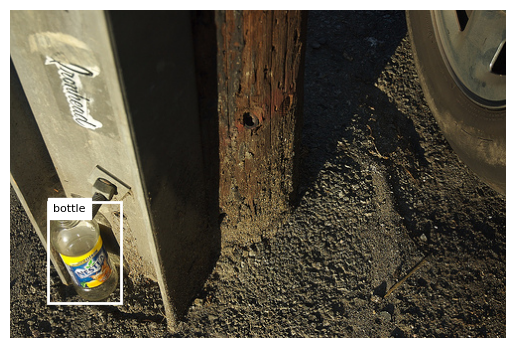

In [3]:
img_id, gtbbs, cat_ids = df.loc[35, ['image_id','bbox','category_id']]
img_path = id2img[img_id]

show_bbs(img_path, gtbbs, [id2label[id] for id in cat_ids])

In [4]:
img = io.read_image(img_path, mode=io.ImageReadMode.RGB)
gtbbs, cat_ids = torch.tensor(gtbbs), torch.tensor(cat_ids)

In [7]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

def extract_rois(img):
    img_np = img.permute(1, 2, 0).numpy()
    h,w = img_np.shape[:2]; img_area = h*w
    _, regions = selective_search(img_np, scale=200, min_size=100)
    unique_rois = set()
    for r in regions:
        rect, size = r['rect'], r['size']
        if (size>0.05*img_area) and (size<img_area) and (rect not in unique_rois):
            unique_rois.add(rect)
    rois = torch.empty((0, 4))
    if len(unique_rois)>0:
        rois = torch.tensor([list(x) for x in unique_rois], dtype=torch.float32)
    return rois

In [8]:
rois = extract_rois(img)
print(rois.shape, gtbbs.shape)

torch.Size([27, 4]) torch.Size([1, 4])


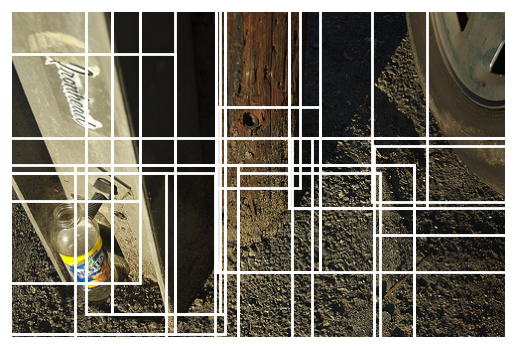

In [9]:
show_bbs(img_path, rois)

In [10]:
r_xyXY = torch.cat([rois[:,:2], rois[:,:2]+rois[:,2:]-1], dim=1)
gt_xyXY = torch.cat([gtbbs[:,:2], gtbbs[:,:2]+gtbbs[:,2:]-1], dim=1)
ious = box_iou(r_xyXY, gt_xyXY)
max_ious, max_idxs = ious.max(dim=1)
valid_mask = max_ious>0.3

ious.shape, torch.sum(valid_mask)

(torch.Size([27, 1]), tensor(0))

In [11]:
def calculate_offsets(rois, gtbbs):
    # Convert to center coordinates
    roi_centers = rois[:, :2] + rois[:, 2:]/2
    gt_centers = gtbbs[:, :2] + gtbbs[:, 2:]/2
    
    # Calculate offsets with numerical stability
    epsilon = 1e-8
    roi_widths = rois[:, 2] + epsilon
    roi_heights = rois[:, 3] + epsilon
    
    dx = (gt_centers[:, 0] - roi_centers[:, 0]) / roi_widths
    dy = (gt_centers[:, 1] - roi_centers[:, 1]) / roi_heights
    dw = torch.log(gtbbs[:, 2] / roi_widths)
    dh = torch.log(gtbbs[:, 3] / roi_heights)
    
    return torch.stack([dx, dy, dw, dh], dim=1)

In [12]:
def apply_offsets(rois, pred_offsets):
    # Convert ROIs to center coordinates
    centers = rois[:, :2] + rois[:, 2:]/2
    widths = rois[:, 2]
    heights = rois[:, 3]
    
    # Unpack offsets
    dx = pred_offsets[:, 0]
    dy = pred_offsets[:, 1]
    dw = pred_offsets[:, 2]
    dh = pred_offsets[:, 3]
    
    # Apply transformations
    refined_centers_x = centers[:, 0] + dx * widths
    refined_centers_y = centers[:, 1] + dy * heights
    refined_widths = widths * torch.exp(dw)
    refined_heights = heights * torch.exp(dh)
    
    # Convert back to [x, y, w, h] format
    refined_boxes = torch.stack([
        refined_centers_x - refined_widths/2,
        refined_centers_y - refined_heights/2,
        refined_widths,
        refined_heights
    ], dim=1)
    
    return refined_boxes

In [13]:
def annotate_rois(rois, gtbbs, cat_ids, cat_thresh=0.3):
    r_xyXY = torch.cat([rois[:,:2], rois[:,:2]+rois[:,2:]-1], dim=1)
    gt_xyXY = torch.cat([gtbbs[:,:2], gtbbs[:,:2]+gtbbs[:,2:]-1], dim=1)
    ious = box_iou(r_xyXY, gt_xyXY)
    max_ious, max_idxs = ious.max(dim=1)
    
    valid_mask = max_ious>cat_thresh
    roi_ids = torch.full((rois.shape[0],), 0, dtype=torch.long)
    roi_ids[valid_mask] = cat_ids[max_idxs[valid_mask]]
    offsets = calculate_offsets(rois, gtbbs[max_idxs])
    return roi_ids, offsets, max_ious

In [14]:
roi_ids, offsets, max_ious = annotate_rois(rois, gtbbs, cat_ids)

roi_ids.shape, offsets.shape, max_ious.shape

(torch.Size([27]), torch.Size([27, 4]), torch.Size([27]))

In [15]:
def get_annotated_rois(row, id2img, cat_thresh=0.3):
    img_id, gtbbs, cat_ids = row[['image_id','bbox','category_id']]
    img = io.read_image(id2img[img_id], mode=io.ImageReadMode.RGB)
    img_id = torch.tensor(img_id, dtype=torch.long)
    gtbbs = torch.tensor(gtbbs, dtype=torch.float32)
    cat_ids = torch.tensor(cat_ids, dtype=torch.long)

    rois = extract_rois(img)
    roi_ids, offsets, max_ious = annotate_rois(rois, gtbbs, cat_ids, cat_thresh)
    img_ids = img_id.repeat(rois.shape[0])
    return img_ids, rois, roi_ids, offsets

In [16]:
from tqdm import tqdm

tqdm.pandas()
res = df.loc[:50].progress_apply(get_annotated_rois, axis=1, id2img=id2img)

100%|███████████████████████████████████████████████████████████████████████████████████| 51/51 [00:56<00:00,  1.10s/it]


In [17]:
img_ids = torch.cat([row[0] for row in res])
rois = torch.cat([row[1] for row in res])
roi_ids = torch.cat([row[2] for row in res])
offsets = torch.cat([row[3] for row in res])